# <span style="color:blue">LDA model (2019_Oct) - with hyperparameter tuning</span>

In [1]:
yyyy_MMM = '2019_Oct'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = True
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10
alpha = 'asymmetric'
eta = 0.61

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model_hyperparameter'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc\2019_Oct\2019_Oct_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter\2019_Oct\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
6942     ['demain', 'commence', 'indre', 'bourges', 'sa...
32657                    ['thabo', 'lot', 'stay', 'bless']
46888    ['cover', 'holiday', 'stone', 'color', 'gold',...
31716    ['king', 'rich', 'life', 'porsche', 'porsche',...
36171    ['love', 'shot', 'hola', 'husband', 'miele', '...
36407    ['perfume', 'free', 'original', 'perfume', 'be...
8610     ['mahir', 'khan', 'fahad', 'mustafa', 'haan', ...
52847    ['clos', 'siete', 'michel', 'roll', 'david', '...
11773              ['lady', 'care', 'keyword', 'consider']
20883                 ['buddy', 'havin', 'mighty', 'duck']
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
28668    ['jeff', 'black', 'model', 'vixenruhhvxo', 'ed...
40521    ['gorgeous', 'bride', 'wonderful', 'move', 'be...
5035     ['lindsay', 'thompson', 'winner', 'master', 'm...
8616     ['super', 'starry', 'company', 'humayun', 'sae...
28618    ['rich', 'leather', 'spike', 'heel', 'fishnet'...
27769    ['britt', 'morgan', 'today', 'bitch', 'holt', ...
6886     ['peinture', 'ence', 'collection', 'priv', 'ma...
32773                         ['amber', 'good', 'weather']
32581          ['posh', 'life', 'hire', 'fire', 'promote']
36103                   ['ella', 'dress', 'olive', 'beth']
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

(4332,)


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

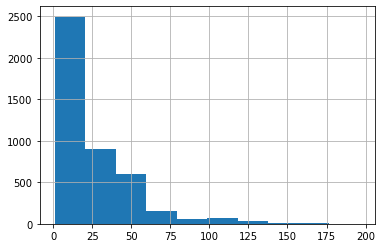

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Build LDA model

In [13]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True
                                       ,alpha=alpha
                                       ,eta=eta)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:25.39


### Incremental learning

In [14]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:29.93
1  -----  500  -----  749
time elapsed - 00:00:30.79
2  -----  750  -----  999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:26.81
3  -----  1000  -----  1249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:27.78
4  -----  1250  -----  1499
time elapsed - 00:00:24.66
5  -----  1500  -----  1749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:28.26
6  -----  1750  -----  1999
time elapsed - 00:00:27.53
7  -----  2000  -----  2249
time elapsed - 00:00:28.05
8  -----  2250  -----  2499
time elapsed - 00:00:25.76
9  -----  2500  -----  2749
time elapsed - 00:00:23.87
10  -----  2750  -----  2999
time elapsed - 00:00:24.36
11  -----  3000  -----  3249
time elapsed - 00:00:26.55
12  -----  3250  -----  3499
time elapsed - 00:00:24.09
13  -----  3500  -----  3749
time elapsed - 00:00:22.88
14  -----  3750  -----  3999
time elapsed - 00:00:23.48
15  -----  4000  -----  4249
time elapsed - 00:00:23.02
16  -----  4250  -----  4499
time elapsed - 00:00:18.62


### Topics in LDA model

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"jones" + 0.015*"cover" + 0.015*"glan" + 0.015*"diwali" + '
  '0.011*"event" + 0.011*"navman" + 0.011*"magazine" + 0.007*"movie" + '
  '0.007*"today" + 0.007*"follow"'),
 (1,
  '0.023*"shoot" + 0.023*"follow" + 0.012*"bethany" + 0.012*"kind" + '
  '0.012*"competition" + 0.012*"gamma" + 0.012*"beta" + 0.012*"moody" + '
  '0.012*"michi" + 0.012*"mini"'),
 (2,
  '0.210*"food" + 0.038*"foodie" + 0.021*"tasty" + 0.019*"breakfast" + '
  '0.019*"yummy" + 0.019*"pic" + 0.019*"ephoto" + 0.019*"gourmand" + '
  '0.019*"lunch" + 0.019*"sweet"'),
 (3,
  '0.035*"luxury" + 0.034*"dress" + 0.023*"couture" + 0.017*"katrina" + '
  '0.012*"fashion" + 0.012*"watch" + 0.012*"haute" + 0.012*"disclaimer" + '
  '0.012*"product" + 0.006*"wedding"'),
 (4,
  '0.049*"jewelry" + 0.022*"york" + 0.018*"city" + 0.018*"jour" + '
  '0.013*"apple" + 0.013*"dessin" + 0.013*"watch" + 0.013*"sapphire" + '
  '0.009*"gold" + 0.009*"time"'),
 (5,
  '0.020*"gourmet" + 0.020*"bos" + 0.014*"tokyo" + 0.013*"eats" + 

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


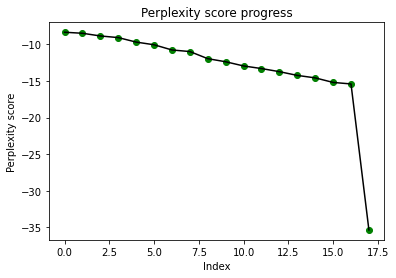

In [16]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


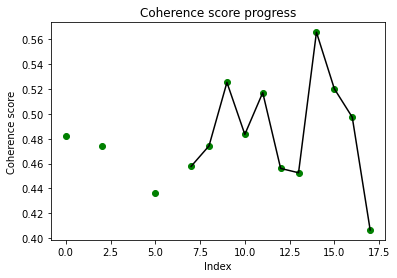

In [17]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.346993 -0.006639       1        1  27.741326
6     -0.043135 -0.261842       2        1  17.530381
0     -0.050917 -0.058975       3        1  13.485376
9     -0.051844  0.019069       4        1   9.494916
4     -0.003492  0.036451       5        1   9.218668
1     -0.049678  0.059083       6        1   5.714062
3     -0.024554  0.048021       7        1   5.481767
7     -0.043688  0.047246       8        1   4.486532
5     -0.037501  0.055686       9        1   3.617939
8     -0.042184  0.061901      10        1   3.229034, topic_info=         Term       Freq      Total Category  logprob  loglift
116      food  76.000000  76.000000  Default  30.0000  30.0000
117    foodie  13.000000  13.000000  Default  29.0000  29.0000
279   jewelry   5.000000   5.000000  Default  28.0000  28.0000
29     bikini   3.000000   3.000000  Default  27.0000  27.0000
31    fitness   3.000000   3.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
2038    michi   0.003666   0.915591  Topic10  -9.3510  -2.0874
396      week   0.003665   1.022183  Topic10  -9.3513  -2.1978
807       day   0.003666   1.127111  Topic10  -9.3512  -2.2954
199    studio   0.003665   1.565501  Topic10  -9.3514  -2.6241
8       shoot   0.003603   3.054828  Topic10  -9.3684  -3.3097

[437 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2151      3  1.432162    airport
1207      2  0.948372  alexander
3249      4  1.674597      allow
4143      2  1.074244      amber
254       1  1.024473  amsterdam
...     ...       ...        ...
105       3  0.383813       year
105       4  0.383813       year
524       2  0.292563       york
524       5  0.877689       york
270       1  1.002508      yummy

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 10, 5, 2, 4, 8, 6, 9])

### Save document-topic matrix (most significant topic per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [19]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      Document  Topic  Probability
0        28668      1     0.624101
1        40521      3     0.705670
2         5035      8     0.974505
3         8616      7     0.881878
4        28618      1     0.797436
...        ...    ...          ...
4327      8592      9     0.981406
4328     26563      6     0.966762
4329     22850      6     0.814031
4330     28741      7     0.843475
4331     16591      0     0.920338

[4332 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


      Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0        28668  0.332954  0.624126  0.008337  0.006984  0.006007  0.005271   
1        40521  0.010930  0.008224  0.149187  0.705802  0.004749  0.004167   
2         5035  0.005513  0.004184  0.003371  0.002824  0.002429  0.002132   
3         8616  0.025948  0.019526  0.015653  0.013110  0.011276  0.009894   
4        28618  0.014837  0.797423  0.008945  0.007492  0.006444  0.005654   
...        ...       ...       ...       ...       ...       ...       ...   
4327      8592  0.004016  0.003032  0.002444  0.002048  0.001762  0.001546   
4328     26563  0.007299  0.005522  0.004452  0.003730  0.003209  0.002816   
4329     22850  0.040708  0.030925  0.024933  0.020887  0.017970  0.015769   
4330     28741  0.034169  0.025926  0.020777  0.017405  0.014975  0.013140   
4331     16591  0.920338  0.015471  0.012466  0.010443  0.008985  0.007884   

        Topic6    Topic7    Topic8    Topic9  
0     0.004696  

### Save topic-term matrix

In [21]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
